# mRNA Sequence Design via Quantum Approximate Optimization Algorithm

Co-authors: Siona Tagare, Shannen Espinosa, Gun Suer

YQuantum 2024 April 13-14

# Background

The 2023 Nobel Prize in Medicine was awarded to Kariko and Weissman for their key discovery in using messenger RNAs (mRNAs) as a highly effective therapeutic that can be quickly developed and deployed against severe human illnesses. Their discovery led to the development of a safe and effective COVID-19 vaccine by Corbett and Graham in less than twelve months.

Recall the central dogma of biology, wherein DNA is transcribed into mRNA, which is translated into an amino acid sequence to form proteins. mRNA vaccines thus deliver into cells the necessary genetic information from the viral genome to stimulate the immune system and produce antibodies that combat the virus prior to an infection. Currently, mRNA vaccines have the potential to eradicate diseases beyond viral infection, like cancer, without using any substance of the actual disease (by instead simply using the genetic code/instructions for protein production), all with rapid development times and lower costs.

However, the short half-life of mRNA as it is leads to critical limitations in storage, distribution, and efficacy, such as its chemical instability and quick degradation. We aim to design an algorithm that optimizes for enough protein expression in a corresponding immune response by improving structural stability and codon usage.

In [ ]:
import numpy as np
import math

from CAI import CAI
from Bio.Seq import Seq

from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session, Options
from qiskit_aer import AerSimulator

In [ ]:
p = "MSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPY"
p = "NVD"

In [ ]:
def p2codons(p):
    aa_codons = {
        'A': ['GCT', 'GCC', 'GCA', 'GCG'],
        'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
        'N': ['AAT', 'AAC'],
        'D': ['GAT', 'GAC'],
        'C': ['TGT', 'TGC'],
        'Q': ['CAA', 'CAG'],
        'E': ['GAA', 'GAG'],
        'G': ['GGT', 'GGC', 'GGA', 'GGG'],
        'H': ['CAT', 'CAC'],
        'I': ['ATT', 'ATC', 'ATA'],
        'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],
        'K': ['AAA', 'AAG'],
        'M': ['ATG'],
        'F': ['TTT', 'TTC'],
        'P': ['CCT', 'CCC', 'CCA', 'CCG'],
        'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
        'T': ['ACT', 'ACC', 'ACA', 'ACG'],
        'W': ['TGG'],
        'Y': ['TAT', 'TAC'],
        'V': ['GTT', 'GTC', 'GTA', 'GTG'],
    }
    
    codon_seq = []
    for aa in p:
        if aa in aa_codons:
            codons = aa_codons[aa]
            codon_seq.append(codons)
        else:
            codon_seq.append([''])

    return codon_seq

codons = p2codons(p)
print(codons)

# Design

For reference, the spike protein of SARS-CoV-2 is made up of over 1000 amino acids. In designing an mRNA vaccine, we aim for codon optimization in what is, at its core, a combinatorial optimization problem. Each amino acid is encoded by a three-nucleotide sequence called a codon. Since there are 20 common amino acids used in proteins, and there are 64 possible codons (4 nucleotides raised to the power of 3), in a potential mRNA vaccine candidate for SARS-CoV-2, we are looking at 61^999 potential possibilities to encode a protein of that size.

In order to leverage potential advantages in emerging technologies like quantum computing, we designed an algorithm that can efficiently handle the vast search space of possible sequences by using the principles of quantum mechanics to explore complex optimization problems more efficiently than classical computers.

We apply quantum algorithms to mRNA sequence optimization with the goal of finding an mRNA sequence that encodes the target protein while satisfying various constraints, such as maximizing codon usage (via probabilities and CAI), chemical stability (via GC content), and minimizing nucleotide repeats. The system gradually evolves from an initial state representing all possible sequences to a final state corresponding to the optimal solution.

In [ ]:
def probabilities(codon):
    prob = {
        'TTT': 0.176, 'TTC': 0.203,
        'TTA': 0.077, 'TTG': 0.129,
        'TCT': 0.152, 'TCC': 0.177,
        'TCA': 0.122, 'TCG': 0.044,
        'TAT': 0.122, 'TAC': 0.153,
        'TAA': 0.01, 'TAG': 0.008,
        'TGT': 0.106, 'TGC': 0.126,
        'TGA': 0.016, 'TGG': 0.132,
        'CTT': 0.132, 'CTC': 0.196,
        'CTA': 0.072, 'CTG': 0.396,
        'CCT': 0.175, 'CCC': 0.198,
        'CCA': 0.169, 'CCG': 0.069,
        'CAT': 0.109, 'CAC': 0.151,
        'CAA': 0.123, 'CAG': 0.342,
        'CGT': 0.045, 'CGC': 0.104,
        'CGA': 0.062, 'CGG': 0.114,
        'ATT': 0.16, 'ATC': 0.208,
        'ATA': 0.075, 'ATG': 0.22,
        'ACT': 0.131, 'ACC': 0.189,
        'ACA': 0.151, 'ACG': 0.061,
        'AAT': 0.17, 'AAC': 0.191,
        'AAA': 0.244, 'AAG': 0.319,
        'AGT': 0.121, 'AGC': 0.195,
        'AGA': 0.122, 'AGG': 0.12,
        'GTT': 0.11, 'GTC': 0.145,
        'GTA': 0.071, 'GTG': 0.281,
        'GCT': 0.184, 'GCC': 0.277,
        'GCA': 0.158, 'GCG': 0.074,
        'GAT': 0.218, 'GAC': 0.251,
        'GAA': 0.29, 'GAG': 0.396,
        'GGT': 0.108, 'GGC': 0.222,
        'GGA': 0.165, 'GGG': 0.165
    }
    return prob.get(codon, 0)

print(probabilities('GCT'))
print(probabilities('TAG'))

In [ ]:
def gc_content(codon):
    gc_count = 0.5
    total_count = 0
    for c in codon:
        gc_count += codon.count('G') + codon.count('C')
        total_count += len(codon)
    gc_content = gc_count / total_count if total_count > 0 else 0
    return gc_content
    
print(gc_content("GGG"))
print(gc_content("ACC"))
print(gc_content("AAA"))

In [ ]:
def minimize_repeats(codon1, codon2):
    repeat_count = 0

    if codon1[-1] == codon2[0]:
        repeat_count += 2
        if codon1[1] == codon1[-1] and codon1[0] == codon1[-1]:
            repeat_count += 2
        elif codon1[1] == codon1[-1]:
            repeat_count += 1

        if codon2[0] == codon2[1] and codon2[0] == codon2[-1]:
            repeat_count += 2
        elif codon2[0] == codon2[1]:
            repeat_count += 1

    if repeat_count == 0:
        return 1
    else:
        return 1 / repeat_count

print(minimize_repeats("ATT", "ACA"))
print(minimize_repeats("ATT", "TCA"))
print(minimize_repeats("ATT", "TTT"))
print(minimize_repeats("TTT", "TTA"))
print(minimize_repeats("TTT", "TTT"))

In [ ]:
def cai_value(codon1, codon2):
    cai = CAI(Seq(codon1), reference=[Seq(codon2)])
    if math.isnan(cai):
        return 0
    else:
        return cai

print(cai_value("ATA", "ATG"))
print(cai_value("TAG", "GAT"))
print(cai_value("AAT", "AAC"))
print(cai_value("AAC", "ATA"))
print(cai_value("GCG", "AAA"))

In [ ]:
def score(codon1, codon2):
    score = probabilities(codon1) * probabilities(codon2) * gc_content(codon1) * gc_content(codon2) * minimize_repeats(codon1, codon2) * cai_value(codon1, codon2)
    return score * 1000

print(score("ATA", "ATG"))
print(score("TAG", "GAT")) # 0
print(score("AAT", "AAC"))
print(score("AAC", "ATA"))
print(score("GCG", "AAA"))

# Finding matrix for linear coefficients

This matrix is meant to represent the probabililty of selecting a codon for an amino acid. The rows of this matrix represent all potential codons for all the amino acids we have found, and the columns represent all amino acids. Each cell represents the probability of selecting the jth codon for the ith amino acid.

In [ ]:
aa_codons = {
    'A': ['GCT', 'GCC', 'GCA', 'GCG'],
    'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
    'N': ['AAT', 'AAC'],
    'D': ['GAT', 'GAC'],
    'C': ['TGT', 'TGC'],
    'Q': ['CAA', 'CAG'],
    'E': ['GAA', 'GAG'],
    'G': ['GGT', 'GGC', 'GGA', 'GGG'],
    'H': ['CAT', 'CAC'],
    'I': ['ATT', 'ATC', 'ATA'],
    'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],
    'K': ['AAA', 'AAG'],
    'M': ['ATG'],
    'F': ['TTT', 'TTC'],
    'P': ['CCT', 'CCC', 'CCA', 'CCG'],
    'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
    'T': ['ACT', 'ACC', 'ACA', 'ACG'],
    'W': ['TGG'],
    'Y': ['TAT', 'TAC'],
    'V': ['GTT', 'GTC', 'GTA', 'GTG'],
}

codons = p2codons(p)
num_codons = 0

for amino in p:
    for codon in aa_codons[amino]:
        num_codons += 1

weights_matrix = np.zeros((num_codons, len(p)))

#find probabilities
for i, amino in enumerate(p):
    for j, codon in enumerate(codons):
        for k, c in enumerate(codon) :
            if c in aa_codons[amino]:
                weights_matrix[k][i] = probabilities(c)
            
print(weights_matrix)

# Finding matrix for quadratic coefficients

This matrix is meant to represent the stability of the sequence based on how nearest neighbor codons interact

In [ ]:
j_matrix = np.zeros((len(p), len(p)))
codons = p2codons(p)

def calculate_j_matrix():
    for i in range(len(p) - 1):
        j_matrix[i, i + 1] = best_score(codons[i], codons[i + 1])
        j_matrix[i + 1, i] = j_matrix[i, i + 1]
    
    return j_matrix
        
print(calculate_j_matrix())

# Matrix explanations
We create our algorithm by generating linear coefficients and quadratic coefficients for our codons in certain amino acid positions.

# Linear coefficients
The linear coefficients matrix has all possible codons in the rows and all amino acids in the columns. The numbers in these matrices correspond to the probability of selecting the ith codon for the jth amino acid.

For example, with the amino acid sequence NM:
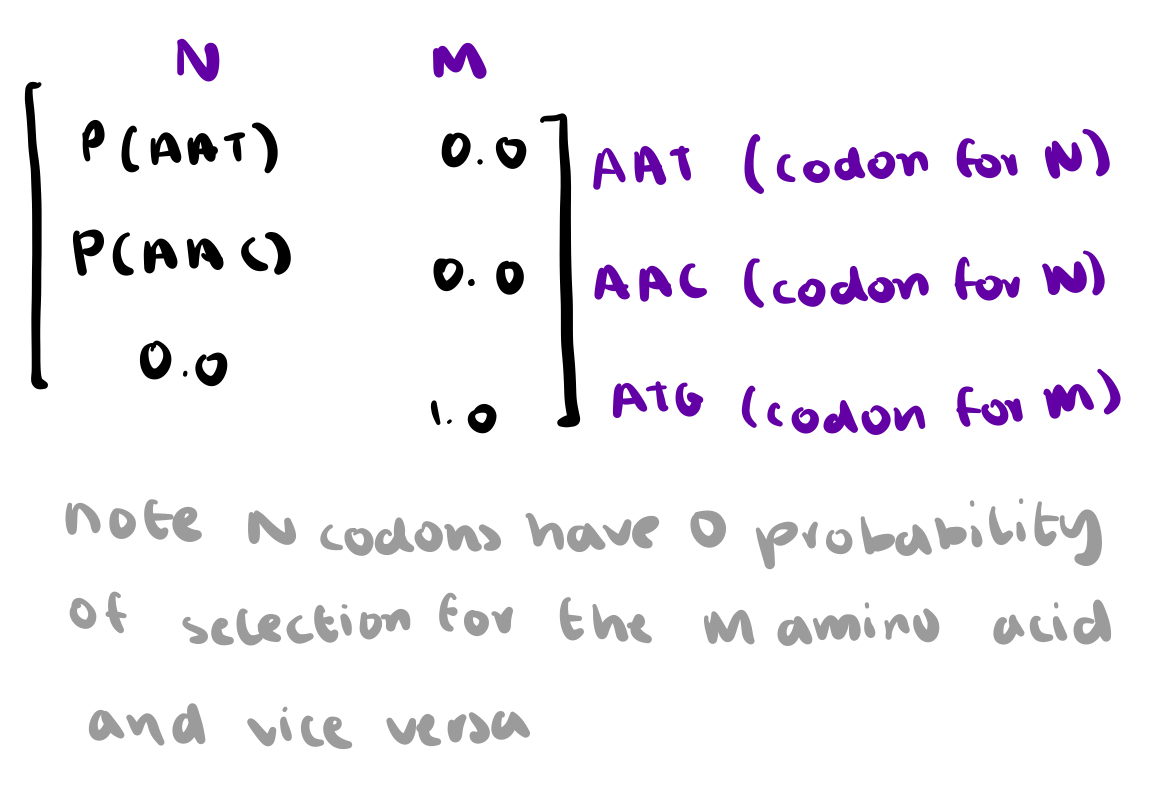

# Quadratic coefficients
The quadratic coefficients represent the stability of the sequence based on a pair of codons. The numbers correspond to the stability if the ith codon is selected for the previous amino acid and the i+1th codon is selected for the current amino acid. This nearest neighbor stability technique is adapted by many codon optimization solutions.

# Algorithm
These coefficients are then attached to a quadratic program alongside constraints to ensure each amino acid has only one codon choice. This quadratic program is maximized to obtain an objective function, and then cast to an Ising hamiltonian by Qiskit's MinimumEigenOptimizer. A QAOA algorithm is applied to obtain final results.

In [ ]:
j_matrix = calculate_j_matrix()
binary_vars = []

qp = QuadraticProgram()
linear_coefficients = {}
quadratic_coefficients = {}

#iterate through each codon for each position, adding a binary variable representing the value 
#of that codon appearing in that position
for i in range(num_codons):
    for j in range(num_positions):
        var = qp.binary_var(name=f'x_{i}_{j}')
        binary_vars.append(var)
        #attach a linear coefficient (representing how likely that codon is to appear in that position)
        #to the ith codon at the jth position 
        linear_coefficients[f'x_{i}_{j}'] = weights_matrix[i, j]
        if j > i:
            #attach a quadratic coefficient (representing the stability of the sequence 
            #if the current codon appears in the current position and the next codon appears in the next position)
            quadratic_coefficients[(f'x_{i}_{j-1}', f'x_{i+1}_{j}')] = j_matrix[i, j]
            
#attach linear constraints so each position can only have one codon appearing with 100% certainty
#all other codons are zero
for j in range(len(j_matrix)):
    constraint_dict = {var_name: 1.0 for var_name in [f'x_{i}_{j}' for i in range(len(j_matrix))]}
    qp.linear_constraint(linear=constraint_dict, sense='==', rhs=1.0)

#obtain the objective function based on coefficients
qp.maximize(linear=linear_coefficients, quadratic=quadratic_coefficients)

# Running on Quantum Computers
We provide code to test our algorithm using both Qiskit's Simulator as well as its cloud computer.

In [ ]:
#to run on computer
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.get_backend("ibmq_qasm_simulator") # delete line when ready
simulator = AerSimulator()

In [ ]:
#to compare with classical results
exact_mes = NumPyMinimumEigensolver()
exact = MinimumEigenOptimizer(exact_mes)
exact_result = exact.solve(qp)
print("classical result")
print_results(exact_result)

In [ ]:
#to simulate results
#define a qaoa to run 
qaoa = QAOA(sampler=simulator, optimizer=COBYLA())

#find the ising hamiltonian and run the qaoa
min_eigen_optimizer = MinimumEigenOptimizer(qaoa)

quantum_result = min_eigen_optimizer.solve(qp)
print("quantum results:")
print_results(quantum_result)